In [6]:
import math
import torch
import torch.nn.functional as F
import torch_geometric.nn as pyg_nn
import scipy.sparse as sp
from torch_geometric.utils import dense_to_sparse
from torch_geometric.utils import degree
import time
import numpy as np
import torch_geometric.transforms as T
from torch_scatter import scatter_mean
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch_geometric.nn as pyg_nn
from torch_scatter import scatter_mean
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch_geometric.nn as pyg_nn
from torch_scatter import scatter_mean
from torch_geometric.nn import GraphNorm
from torch.optim.lr_scheduler import ReduceLROnPlateau
import matplotlib.pyplot as plt

In [30]:
# # Read the file
# with open("mass_numbers_A.txt", "r") as file:
#     lines = file.readlines()

# # Flatten and parse all numbers
# mass_numbers = []
# for line in lines:
#     # Replace commas with spaces if needed, then split
#     numbers = line.replace(',', ' ').split()
#     mass_numbers.extend([float(num) for num in numbers])  # Use int(num) if you want integers

# # Convert to torch tensor
# A = torch.tensor(mass_numbers, dtype= torch.double)

In [2]:
class NodeGenerator:
    def __init__(self):
        from torch_geometric.nn.aggr.fused import FusedAggregation
        self.aggr = FusedAggregation(['max', 'min', 'mean', 'var'])  # Aggregators

    def __call__(self, x, edge_index, num_nodes):
        row, col = edge_index

        # Compute node degrees
        deg = degree(row, num_nodes, dtype=torch.float).view(-1, 1)

        # Compute neighbor statistics (min, max, mean, std of neighboring degrees)
        neighbor_stats = self.aggr(deg[col], row, dim_size=num_nodes)

        # Concatenate LDP features
        ldp_features = torch.cat([deg] + neighbor_stats, dim=-1)

        # Append LDP features to x
        if x is not None:
            x = x.view(-1, 1) if x.dim() == 1 else x  # Ensure x has correct dimensions
            x = torch.cat([x, ldp_features], dim=-1)
        else:
            x = ldp_features  # If x is None, use only LDP features

        return x.to(dtype=torch.float64)


In [32]:
# class SafeSensitiveLoss(nn.Module):
#     def __init__(self, eps=1e-20, threshold=1e-15):
#         super(SafeSensitiveLoss, self).__init__()
#         self.eps = eps
#         self.threshold = threshold

#     def forward(self, pred, target):
#         # Create mask for very small targets
#         small_mask = (target.abs() < self.threshold).float()

#         # Relative error when target is large enough
#         relative_error = ((pred - target) / (target + self.eps)) ** 2

#         # Fallback to absolute error when target ~ 0
#         absolute_error = (pred - target) ** 2

#         # Combine based on mask
#         loss = small_mask * absolute_error + (1 - small_mask) * relative_error
#         return torch.mean(loss)
# criterion = SafeSensitiveLoss()

In [3]:
class GraphAutoencoder(nn.Module):
    def __init__(self, in_channels, out_channels,MLP_dim, hidden_dim, hidden_dim_edge, num_layers):
        super(GraphAutoencoder, self).__init__()
        negslope = 0.01

        self.num_layers = num_layers
        self.Graphconv = nn.ModuleList()
        self.residue_layers = nn.ModuleList()
        self.conv_layers = nn.ModuleList()
        self.edge_mlp_layers = nn.ModuleList()
        self.init = nn.Sequential(
            nn.Linear(in_channels, MLP_dim, dtype=torch.float64),
            nn.ReLU(),
            nn.Linear(MLP_dim,MLP_dim , dtype=torch.float64)
        )
        
        self.Graphconv.append(
            pyg_nn.GraphConv(MLP_dim, hidden_dim))
        
        for _ in range(1, num_layers):
            self.Graphconv.append(
#                 pyg_nn.GATConv(hidden_dim + 1, hidden_dim, aggr="mean")
                pyg_nn.GraphConv(hidden_dim, hidden_dim)
            )
        
        
        self.residue_layers.append(
            nn.Sequential(
            nn.Linear(MLP_dim, hidden_dim)
            )
        )
        for _ in range(1, num_layers):
            self.residue_layers.append(
                nn.Sequential(
                    nn.Linear(hidden_dim, hidden_dim)
                )
            )
        
        # Initial GraphConv and GraphNorm layer
        self.conv_layers.append(
#             pyg_nn.GATConv(in_channels + 1, hidden_dim, aggr="mean")
            nn.Sequential(
                nn.Linear(MLP_dim+ 1, hidden_dim, dtype=torch.float64),
                nn.LeakyReLU(negative_slope=negslope),
                nn.Linear(hidden_dim, hidden_dim, dtype=torch.float64)
            )
        )
        # Remaining layers
        for _ in range(1, num_layers):
            self.conv_layers.append(
#                 pyg_nn.GATConv(hidden_dim + 1, hidden_dim, aggr="mean")
                nn.Sequential(
                    nn.Linear(hidden_dim+1, hidden_dim, dtype=torch.float64),
                    nn.LeakyReLU(negative_slope=negslope),
                    nn.Linear(hidden_dim,hidden_dim , dtype=torch.float64)
                )
            )
        # Edge MLPs
        self.edge_mlp_layers.append(
            nn.Sequential(
                nn.Linear(MLP_dim * 2 + 1, hidden_dim_edge, dtype=torch.float64),
                nn.LeakyReLU(negative_slope=negslope),
                nn.Linear(hidden_dim_edge, 1, dtype=torch.float64)
            )
        )
        for _ in range(1, num_layers):
            self.edge_mlp_layers.append(
                nn.Sequential(
                    nn.Linear(hidden_dim * 2 + 1, hidden_dim_edge, dtype=torch.float64),
                    nn.LeakyReLU(negative_slope=negslope),
                    nn.Linear(hidden_dim_edge, 1, dtype=torch.float64)
                )
            )

        # Final prediction MLP
        self.pred = nn.Sequential(
            nn.Linear(hidden_dim, MLP_dim, dtype=torch.float64),
            nn.ReLU(),
            nn.Linear(MLP_dim, out_channels, dtype=torch.float64)
        )
        self.reset_parameters()
        
        
    def reset_parameters(self):
        gain_val=nn.init.calculate_gain('relu')    
        for mlp in self.edge_mlp_layers:
            for layer in mlp:
                if isinstance(layer, nn.Linear):
                    nn.init.xavier_normal_(layer.weight,gain =gain_val)
                    nn.init.zeros_(layer.bias)
                    
        for mlp in self.conv_layers:
            for layer in mlp:
                if isinstance(layer, nn.Linear):
                    nn.init.xavier_normal_(layer.weight, gain=gain_val)
                    nn.init.zeros_(layer.bias)

        for layer in self.pred:
            if isinstance(layer, nn.Linear):
                nn.init.xavier_normal_(layer.weight,gain =gain_val)
                nn.init.zeros_(layer.bias)
        print('initialised')

    def forward(self, x, edge_index, edge_feat):
        edge_feat = edge_feat.unsqueeze(-1).to(dtype=torch.float64)
        edge_features = edge_feat
        x = x.to(dtype=torch.float64)
        tau = torch.norm(x, p = 'fro')
        row, col = edge_index
        x = torch.mul(x,np.sqrt(7836)/tau)
        x = F.relu(self.init(x))
        for i in range(self.num_layers):
            # Concatenate edge_feat with source and target node features
            res = self.residue_layers[i](x)
            edge_input = torch.cat([edge_features, x[row], x[col]], dim=1).to(dtype=torch.float64)
            edge_features = self.edge_mlp_layers[i](edge_input)
                
            # Aggregate edge features back to nodes
            agg = scatter_mean(edge_features, row, dim=0, dim_size=x.size(0))
            x_agg = torch.cat([x, agg], dim=1)
            # Apply GraphConv, then GraphNorm, then activation
            x = self.conv_layers[i](x_agg)
#             x = self.Graphconv[i](x, edge_index,edge_feat)
            x = torch.add(x,res)
            x = F.relu(x)

        # Final edge features for prediction
        x = self.pred(x)
        x = torch.mul(x,tau/np.sqrt(7836))

        return x


def csr_to_graph_data(csr_matrix):
    adj_matrix = torch.tensor(csr_matrix.toarray(), dtype=torch.float64)
    edge_index, edge_weights = dense_to_sparse(adj_matrix)
    n = csr_matrix.shape[0]
    feat = np.zeros((n, 1), dtype=np.float64)
    for i in range(n):
        feat[i] = i + 1

    return edge_index, edge_weights.to(dtype=torch.float64)


In [4]:
def csr_matrix_generator(file_path):
    """
    Generator that reads 4 lines at a time from file and yields:
    - A CSR matrix (scipy.sparse.csr_matrix)
    - The L2 norm of values (a)
    - A (N, 2) torch tensor of [diagonal dominance, diagonal decay] per row
    """
    with open(file_path, 'r') as f:
        while True:
            block = []
            for _ in range(5):
                line = f.readline()
                if not line:
                    return
                block.append(line.strip().split())

            rowpt = np.array(block[0], dtype=int)
            clmnind = np.array(block[1], dtype=int)
            vals = np.array(block[2], dtype=np.float64)
            rhs = torch.tensor([float(x) for x in block[3]], dtype=torch.float64).unsqueeze(1)
            X = torch.tensor([float(x) for x in block[4]], dtype=torch.float64).unsqueeze(1)

            matrix = sp.csr_matrix((vals, clmnind, rowpt), dtype=np.float64, shape=(7836, 7836))
            abs_matrix = abs(matrix)
            row_sums = abs_matrix.sum(axis=1).A.flatten()
            col_sums = abs_matrix.sum(axis=0).A.flatten()
            gamma = min(np.max(row_sums), np.max(col_sums))

            yield matrix,gamma, rhs, X

# Example usage:
file_path = 'GenData.txt'
matrix_gen = csr_matrix_generator(file_path)

# First call reads the first 4 lines
#first_matrix = next(matrix_gen)

# # Next call reads the next 4 lines
# second_matrix = next(matrix_gen)

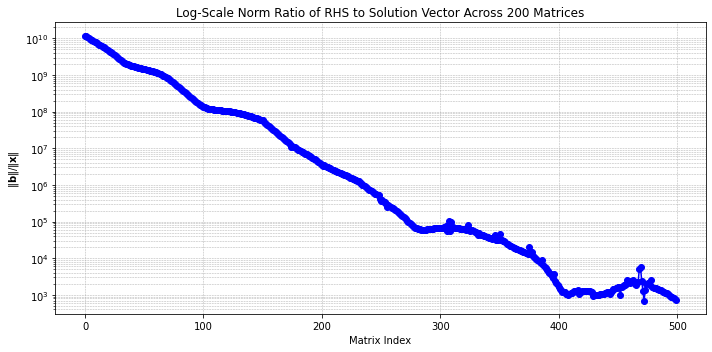

In [7]:
ratios = []
for _ in range(500):
    matrix, gamma, rhs, X = next(matrix_gen)

    # Ensure the tensors are in float64 if needed
    rhs = rhs.to(dtype=torch.float64)
    X = X.to(dtype=torch.float64)

    # Compute the norms
    norm_rhs = torch.norm(rhs, p=2)
    norm_X = torch.norm(X, p=2)

    # Compute and store the ratio, avoiding division by zero
    ratio = (norm_rhs / norm_X).item() if norm_X > 0 else float('inf')
    ratios.append(ratio)

# Plotting the ratio across instances
plt.figure(figsize=(10, 5))
plt.plot(ratios, marker='o', linestyle='-', color='blue')
plt.yscale("log")  # Set y-axis to logarithmic scale
plt.xlabel("Matrix Index")
plt.ylabel(r"$\|\mathbf{b}\| / \|\mathbf{x}\|$")
plt.title("Log-Scale Norm Ratio of RHS to Solution Vector Across 200 Matrices")
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()

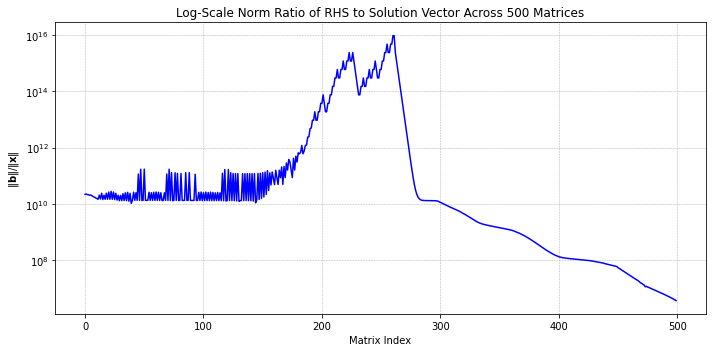

In [165]:
plt.figure(figsize=(10, 5))
plt.plot(ratios, linestyle='-', color='blue')  # Removed marker='o'
plt.yscale("log")  # Set y-axis to logarithmic scale
plt.xlabel("Matrix Index")
plt.ylabel(r"$\|\mathbf{b}\| / \|\mathbf{x}\|$")
plt.title("Log-Scale Norm Ratio of RHS to Solution Vector Across 500 Matrices")
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()

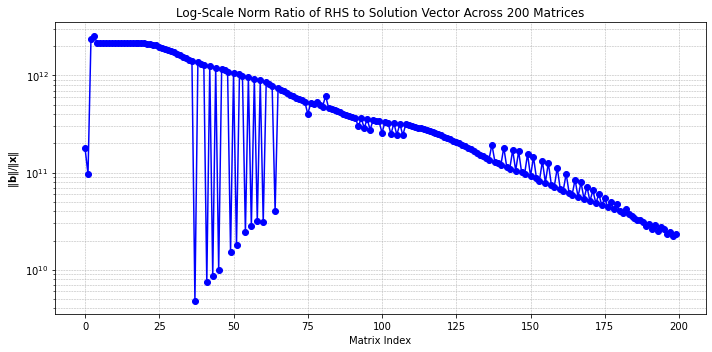

In [162]:
plt.figure(figsize=(10, 5))
plt.plot(ratios, marker='o', linestyle='-', color='blue')
plt.yscale("log")  # Set y-axis to logarithmic scale
plt.xlabel("Matrix Index")
plt.ylabel(r"$\|\mathbf{b}\| / \|\mathbf{x}\|$")
plt.title("Log-Scale Norm Ratio of RHS to Solution Vector Across 200 Matrices")
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()

In [148]:
# def csr_lu_generator(file_path):
#     """
#     Coroutine generator that reads 3 lines at a time from a file and yields a CSR matrix.
#     Takes input `a` each time via `send(a)` and divides the values by `a`.
#     """
#     with open(file_path, 'r') as f:
#         while True:
#             block = []
#             for _ in range(3):
#                 line = f.readline()
#                 if not line:
#                     return  # End of file
#                 block.append(line.strip().split())

#             rowpt = np.array(block[0], dtype=int)
#             clmnind = np.array(block[1], dtype=int)
#             vals = np.array(block[2], dtype=np.float64)

#             mean = np.mean(vals)
#             std = np.std(vals)
#             vals = (vals - mean) / std
#             matrix = sp.csr_matrix((vals, clmnind, rowpt), dtype=np.float64, shape=(7836, 7836))
#             yield matrix 

# # Example usage:
# file_path = 'Output.txt'
# lu_gen = csr_lu_generator(file_path)
# #next(lu_gen)

# # First call reads the first 4 lines
# #first_lu = next(lu_gen)

# # # Next call reads the next 4 lines
# # second_matrix = next(matrix_gen)

In [8]:
device = "cpu"
model = GraphAutoencoder(in_channels = 1, out_channels=1,MLP_dim = 16, hidden_dim=32, hidden_dim_edge=8, num_layers = 10)
model = model.to(torch.float64)
for param in model.parameters():
      param.requires_grad = True
        
# edge_index, node_features = csr_to_graph_data(matrix)

# === Train Model === #

optimizer = torch.optim.Adam(model.parameters(), lr= 0.001) # adj_matrix = adj_matrix.to(device)
scheduler = ReduceLROnPlateau(optimizer, mode="min", factor=0.5, patience=10)
# transform =NodeGenerator()
# x = transform(node_features,edge_index,N).to(device)
# edge_index = edge_index.to(device)

initialised


In [36]:
# def get_output(LU, edge_index):
#     """
#     Efficiently retrieves the LU values at the given edge indices.

#     :param LU: SciPy sparse CSR matrix (shape: NxN).
#     :param edge_index: PyTorch LongTensor (2 x num_edges) specifying row and column indices.
#     :return: PyTorch tensor (1 x num_edges) containing the LU values at given indices (dtype: float64).
#     """
#     # Convert LU to a COO sparse matrix for efficient indexing
#     LU_coo = LU.tocoo()

#     # Create a PyTorch sparse tensor from LU
#     LU_tensor = torch.sparse_coo_tensor(
#         torch.stack([torch.tensor(LU_coo.row), torch.tensor(LU_coo.col)]),
#         torch.tensor(LU_coo.data, dtype=torch.float64),
#         size=LU.shape
#     ).coalesce()

#     # Extract and cast values from LU at given edge indices
#     edge_values = LU_tensor.to_dense()[edge_index[0], edge_index[1]].to(dtype=torch.float64)

#     return edge_values.unsqueeze(0)  # shape: (1, num_edges)

In [9]:
def csr_to_sparse_tensor(matrix):
    matrix = matrix.tocoo()
    indices = torch.tensor([matrix.row, matrix.col], dtype=torch.long)
    values = torch.tensor(matrix.data, dtype=torch.float64)
    shape = matrix.shape
    return torch.sparse_coo_tensor(indices, values, size=shape, dtype=torch.float64)

max_grad_norm = 1
num_epochs = 200
batch_size = 1

N = 7836
scaling_factor = 1e20  # Scale target and predictions for numerical stability

for epoch in range(num_epochs):
    model.train()
    optimizer.zero_grad()
    total_loss = 0

    for i in range(batch_size):
        matrix,gamma, rhs, X = next(matrix_gen)
        edge_index, edge_feat = csr_to_graph_data(matrix)
        edge_feat = torch.mul(edge_feat, 1/gamma).to(dtype=torch.float64)
        rhs = rhs.to(dtype=torch.float64)
        X = X.to(dtype=torch.float64)

        # Forward pass
        pred = model(rhs, edge_index, edge_feat)

#         # Scale targets and predictions to O(1) range
#         X_scaled = X * scaling_factor
#         pred_scaled = pred * scaling_factor
#         torch_matrix = csr_to_sparse_tensor(matrix)
#         pred_transformed = torch.sparse.mm(torch_matrix, pred)
#         X_transformed = torch.sparse.mm(torch_matrix, X)
#         weighted_sum = torch.abs(torch.dot(A, pred.squeeze()))

        # Compute base loss
        loss = F.l1_loss(pred, X) 
        # Or, optionally:
        # loss = F.smooth_l1_loss(pred_scaled, X_scaled, beta=0.01)
        # loss = F.l1_loss(pred_scaled, X_scaled)

        total_loss += loss

    total_loss /= batch_size
    total_loss.backward()

    # Gradient clipping
#     torch.nn.utils.clip_grad_norm_(model.parameters(), max_grad_norm)
    optimizer.step()
    scheduler.step(total_loss)
#     file_path = 'GenData.txt'
#     matrix_gen = csr_matrix_generator(file_path)

    print(f"Epoch {epoch:03d} | Loss:  {total_loss.item():.15f}  | LR: {optimizer.param_groups[0]['lr']:.6e}")


Epoch 000 | Loss:  0.004133475888559  | LR: 1.000000e-03
Epoch 001 | Loss:  0.003615058348919  | LR: 1.000000e-03
Epoch 002 | Loss:  0.001781429706084  | LR: 1.000000e-03
Epoch 003 | Loss:  0.002211978480627  | LR: 1.000000e-03
Epoch 004 | Loss:  0.000649642846813  | LR: 1.000000e-03
Epoch 005 | Loss:  0.000342092014116  | LR: 1.000000e-03
Epoch 006 | Loss:  0.000086408118338  | LR: 1.000000e-03
Epoch 007 | Loss:  0.000123751576486  | LR: 1.000000e-03
Epoch 008 | Loss:  0.000149575572965  | LR: 1.000000e-03
Epoch 009 | Loss:  0.000150544224630  | LR: 1.000000e-03
Epoch 010 | Loss:  0.000059853646007  | LR: 1.000000e-03
Epoch 011 | Loss:  0.000115219613355  | LR: 1.000000e-03
Epoch 012 | Loss:  0.000168933970738  | LR: 1.000000e-03
Epoch 013 | Loss:  0.000171153143993  | LR: 1.000000e-03
Epoch 014 | Loss:  0.000063316026127  | LR: 1.000000e-03
Epoch 015 | Loss:  0.000122888300645  | LR: 1.000000e-03
Epoch 016 | Loss:  0.000134578391947  | LR: 1.000000e-03
Epoch 017 | Loss:  0.0001502671

Epoch 144 | Loss:  0.000004679636146  | LR: 3.125000e-05
Epoch 145 | Loss:  0.000006187862011  | LR: 3.125000e-05
Epoch 146 | Loss:  0.000006862646420  | LR: 3.125000e-05
Epoch 147 | Loss:  0.000005023801939  | LR: 3.125000e-05
Epoch 148 | Loss:  0.000005885826320  | LR: 1.562500e-05
Epoch 149 | Loss:  0.000007045819860  | LR: 1.562500e-05
Epoch 150 | Loss:  0.000006259043435  | LR: 1.562500e-05
Epoch 151 | Loss:  0.000004910280662  | LR: 1.562500e-05
Epoch 152 | Loss:  0.000006111131214  | LR: 1.562500e-05
Epoch 153 | Loss:  0.000006818330880  | LR: 1.562500e-05
Epoch 154 | Loss:  0.000006771522989  | LR: 1.562500e-05
Epoch 155 | Loss:  0.000005182381879  | LR: 1.562500e-05
Epoch 156 | Loss:  0.000006076187766  | LR: 1.562500e-05
Epoch 157 | Loss:  0.000006922100247  | LR: 1.562500e-05
Epoch 158 | Loss:  0.000006159638680  | LR: 1.562500e-05
Epoch 159 | Loss:  0.000005611818316  | LR: 7.812500e-06
Epoch 160 | Loss:  0.000006055084675  | LR: 7.812500e-06
Epoch 161 | Loss:  0.0000063326

In [10]:
import numpy as np
from scipy.sparse import csr_matrix

def bicgstab_flexible(A_csr, b, x0=None, tol=1e-8, maxiter=None, M_func=None, verbose=False):
    """
    BiCGSTAB solver with flexible preconditioning for CSR matrices.
    
    Parameters:
        A_csr : scipy.sparse.csr_matrix
            The sparse matrix A.
        b : numpy.ndarray
            Right-hand side vector.
        x0 : numpy.ndarray, optional
            Initial guess (default is zero vector).
        tol : float, optional
            Convergence tolerance.
        maxiter : int, optional
            Maximum iterations (default is 2n).
        M_func : function, optional
            Preconditioner function: M_func(v) ≈ M^{-1}v (can vary each iteration).
        verbose : bool, optional
            Print residual norm each iteration.
    
    Returns:
        x : numpy.ndarray
            Approximate solution.
        info : int
            0 if successful, >0 if not converged, <0 if breakdown.
    """
    if not isinstance(A_csr, csr_matrix):
        raise TypeError("A_csr must be a scipy.sparse.csr_matrix.")
    
    b = b.ravel()
    n = A_csr.shape[0]
    if x0 is None:
        x = np.zeros(n)
    else:
        x = x0.ravel().copy()

    if maxiter is None:
        maxiter = 2 * n

    r = b - A_csr.dot(x)
    r_hat = r.copy()
    rho_old = alpha = omega = 1.0
    v = p = np.zeros_like(b)

    for i in range(maxiter):
        if verbose:
            print(f"Iteration {i}: residual norm = {np.linalg.norm(r):.2e}")
        
        rho_new = np.dot(r_hat, r)
        if np.abs(rho_new) < 1e-30:
            return x, -1  # Breakdown

        if i == 0:
            p = r.copy()
        else:
            beta = (rho_new / rho_old) * (alpha / omega)
            p = r + beta * (p - omega * v)

        y = M_func(p) if M_func is not None else p
        v = A_csr.dot(y)

        v_dot = np.dot(r_hat, v)
        if np.abs(v_dot) < 1e-30:
            return x, -2  # Breakdown
        alpha = rho_new / v_dot

        s = r - alpha * v
        if np.linalg.norm(s) < tol:
            x += alpha * y
            return x, 0

        z = M_func(s) if M_func is not None else s
        t = A_csr.dot(z)

        t_dot_t = np.dot(t, t)
        if np.abs(t_dot_t) < 1e-30:
            return x, -3  # Breakdown
        omega = np.dot(t, s) / t_dot_t

        x += alpha * y + omega * z
        r = s - omega * t
        if np.linalg.norm(r) < tol:
            return x, 0


        rho_old = rho_new

    return x, maxiter  # Did not converge


Matrix 1: ‖r₀‖ with precond = 1.72e+00, without = 1.33e+00
Matrix 2: ‖r₀‖ with precond = 1.74e+00, without = 1.34e+00
Matrix 3: ‖r₀‖ with precond = 1.74e+00, without = 1.36e+00
Matrix 4: ‖r₀‖ with precond = 1.74e+00, without = 1.39e+00
Matrix 5: ‖r₀‖ with precond = 1.76e+00, without = 1.39e+00


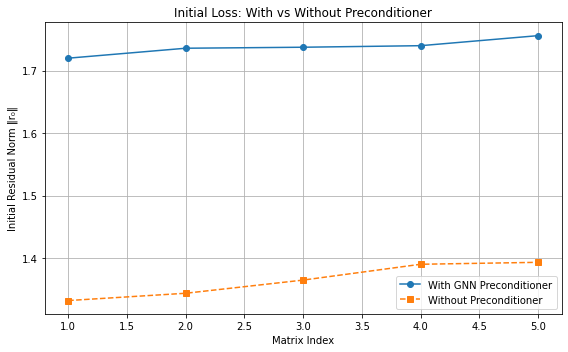

In [15]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from scipy.sparse import csr_matrix

# Modified BiCGSTAB to return first residual norm
def bicgstab_flexible(A_csr, b, x0=None, tol=1e-8, maxiter=None, M_func=None):
    if not isinstance(A_csr, csr_matrix):
        raise TypeError("A_csr must be a scipy.sparse.csr_matrix.")
    
    b = b.ravel()
    n = A_csr.shape[0]
    x = np.zeros(n) if x0 is None else x0.ravel().copy()
    if maxiter is None:
        maxiter = 2 * n

    r = b - A_csr.dot(x)
    initial_res_norm = np.linalg.norm(r)
    r_hat = r.copy()
    rho_old = alpha = omega = 1.0
    v = p = np.zeros_like(b)

    for i in range(maxiter):
        rho_new = np.dot(r_hat, r)
        if np.abs(rho_new) < 1e-30:
            return x, -1,  np.linalg.norm(r)

        if i == 0:
            p = r.copy()
        else:
            beta = (rho_new / rho_old) * (alpha / omega)
            p = r + beta * (p - omega * v)

        y = M_func(p) if M_func is not None else p
        v = A_csr.dot(y)

        v_dot = np.dot(r_hat, v)
        if np.abs(v_dot) < 1e-30:
            return x, -2,  np.linalg.norm(r)
        alpha = rho_new / v_dot

        s = r - alpha * v
        if np.linalg.norm(s) < tol:
            x += alpha * y
            return x, 0,  np.linalg.norm(r)

        z = M_func(s) if M_func is not None else s
        t = A_csr.dot(z)

        t_dot_t = np.dot(t, t)
        if np.abs(t_dot_t) < 1e-30:
            return x, -3,  np.linalg.norm(r)
        omega = np.dot(t, s) / t_dot_t

        x += alpha * y + omega * z
        r = s - omega * t
        if np.linalg.norm(r) < tol:
            return x, 0, np.linalg.norm(r)

        rho_old = rho_new

    return x, maxiter, np.linalg.norm(r)

# Storage
residuals_with_precond = []
residuals_no_precond = []

num_matrices = 5  # Adjust as needed

for i in range(num_matrices):
    matrix, gamma, rhs, X = next(matrix_gen)

    # GNN setup
    edge_index, edge_feat = csr_to_graph_data(matrix)
    edge_feat = torch.mul(edge_feat, 1 / gamma).to(dtype=torch.float64)
    b = rhs.numpy().ravel()

    # Flexible preconditioner with GNN
    def flexible_preconditioner(v):
        v_tensor = torch.from_numpy(v).to(dtype=torch.float64).unsqueeze(1)
        with torch.no_grad():
            out = model(v_tensor, edge_index, edge_feat)
        return out.detach().cpu().numpy().ravel()

#     ilu = spilu(matrix)
#     def flexible_preconditioner(v):
#         x =ilu.solve(v)
#         return x

    # With preconditioner
    _, _, res1 = bicgstab_flexible(matrix, b, maxiter=1, M_func=flexible_preconditioner)
    residuals_with_precond.append(res1)

    # Without preconditioner
    _, _, res2 = bicgstab_flexible(matrix, b, maxiter=1, M_func=None)
    residuals_no_precond.append(res2)

    print(f"Matrix {i+1}: ‖r₀‖ with precond = {res1:.2e}, without = {res2:.2e}")

# Plotting
plt.figure(figsize=(8, 5))
plt.plot(range(1, num_matrices + 1), residuals_with_precond, 'o-', label='With GNN Preconditioner')
plt.plot(range(1, num_matrices + 1), residuals_no_precond, 's--', label='Without Preconditioner')
plt.xlabel("Matrix Index")
plt.ylabel("Initial Residual Norm ‖r₀‖")
plt.title("Initial Loss: With vs Without Preconditioner")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
